In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from TOV_Solver import WaveNetTOV, evaluate_model
import matplotlib.pyplot as plt
import joblib
from TOV_Solver import tov_load_and_preprocess
from preprocessing import _resample_group


Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Train Loss: 0.000186 | Val Loss: 0.000187 | Val R²: 0.997314 | LR: 1.000000e-05
ckpt = torch.load("models/tov_solver.pt", map_location=device)

# 3️⃣ If it's a dict:
model = WaveNetTOV()
model.load_state_dict(ckpt)
model.eval()

C:\Users\ppsan\AppData\Local\Temp\ipykernel_14280\3659714441.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("models/tov_solver.pt", map_location=devic

WaveNetTOV(
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
  (input_conv): CausalConv1d()
  (hidden_layers): ModuleList(
    (0-7): 8 x CausalConv1d()
  )
  (output_conv): CausalConv1d()
)

Input Data

In [4]:
df = pd.read_csv("data/sample_mr.csv")

# pick one ID/model pair
group = df[(df["ID"] == df["ID"].iloc[0]) & (df["model"] == df["model"].iloc[0])]

out = _resample_group(group, column="M", Np=32)
print(out)

        ID  model          R         M
0   8293.0  RMFNL  15.913761  0.193988
1   8293.0  RMFNL  14.418227  0.228143
2   8293.0  RMFNL  13.081025  0.316169
3   8293.0  RMFNL  12.769663  0.369882
4   8293.0  RMFNL  12.401650  0.495269
5   8293.0  RMFNL  12.317287  0.565883
6   8293.0  RMFNL  12.310873  0.719200
7   8293.0  RMFNL  12.349771  0.800129
8   8293.0  RMFNL  12.413623  0.965780
9   8293.0  RMFNL  12.425175  1.048601
10  8293.0  RMFNL  12.465156  1.209894
11  8293.0  RMFNL  12.458322  1.286869
12  8293.0  RMFNL  12.425822  1.430502
13  8293.0  RMFNL  12.410751  1.496295
14  8293.0  RMFNL  12.321292  1.614454
15  8293.0  RMFNL  12.265577  1.666550
16  8293.0  RMFNL  12.135769  1.756712
17  8293.0  RMFNL  12.071940  1.794936
18  8293.0  RMFNL  11.909753  1.858417
19  8293.0  RMFNL  11.823018  1.884070
20  8293.0  RMFNL  11.641358  1.924325
21  8293.0  RMFNL  11.547751  1.939403
22  8293.0  RMFNL  11.357532  1.960659
23  8293.0  RMFNL  11.261810  1.967301
24  8293.0  RMFNL  11.070

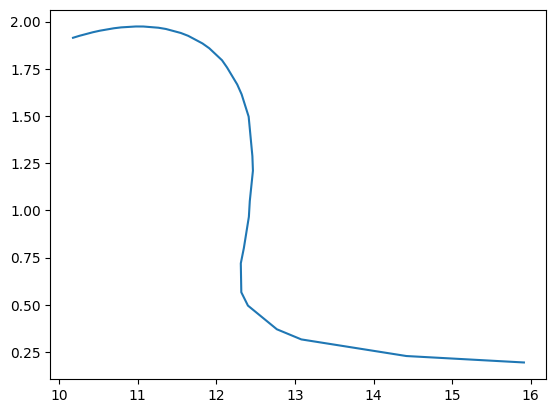

In [5]:
R = out["R"].to_numpy()
M = out["M"].to_numpy()

plt.plot(R, M)
plt.show()

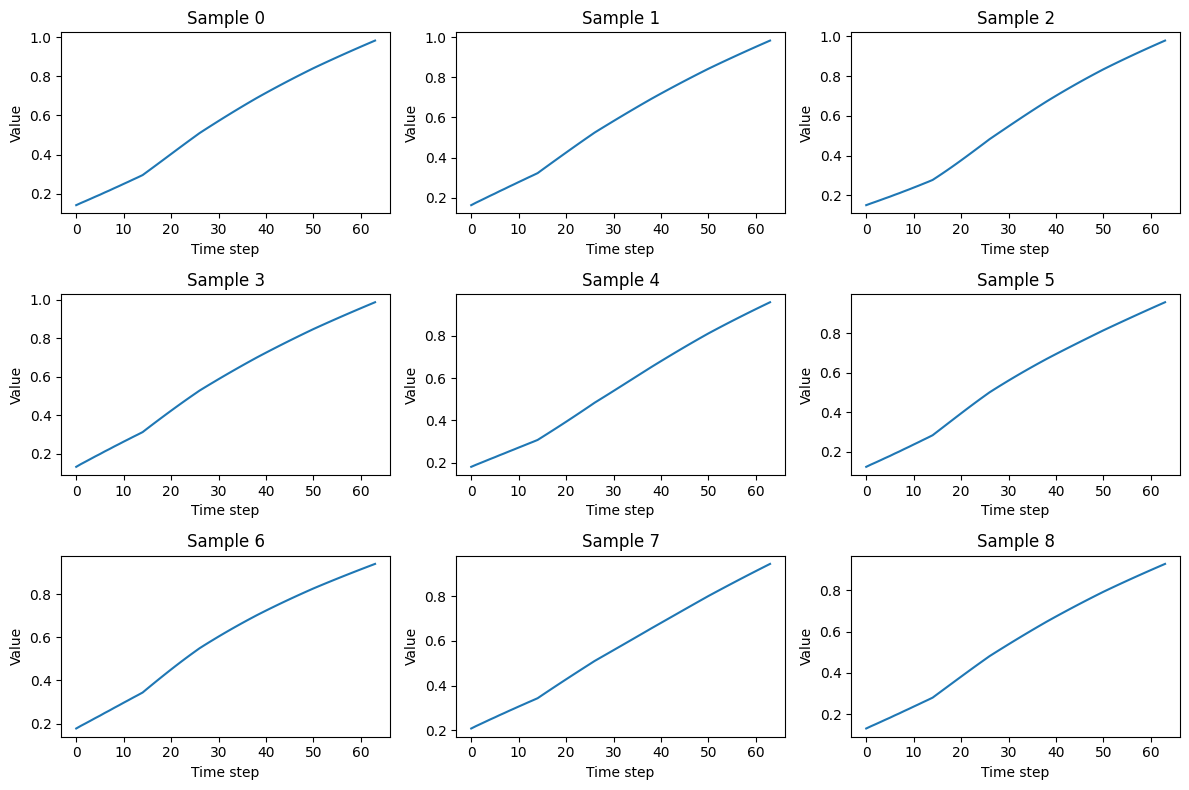

In [6]:
X_scaled = np.load("data/X_scaled.npy")
X_scaled.shape

# Plot first few samples
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(9):
    axes[i].plot(X_scaled[i, :, 1])  # Extract the feature dimension
    axes[i].set_title(f'Sample {i}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Value')
    
plt.tight_layout()

In [7]:
X_scaled[:,:, 1].max()

np.float32(1.0)

In [8]:
X_scaled[:,:, 1]

array([[0.14194706, 0.15307093, 0.1634052 , ..., 0.9612348 , 0.9716647 ,
        0.98202163],
       [0.162712  , 0.17504302, 0.18641113, ..., 0.9619115 , 0.9723217 ,
        0.9826621 ],
       [0.15092997, 0.15975624, 0.16807808, ..., 0.95731086, 0.9678726 ,
        0.9783428 ],
       ...,
       [0.08357091, 0.09539585, 0.10633247, ..., 0.9284487 , 0.93906784,
        0.9495926 ],
       [0.05659191, 0.07020752, 0.08265848, ..., 0.9290894 , 0.9397489 ,
        0.95031863],
       [0.08665802, 0.09845359, 0.10936509, ..., 0.9277869 , 0.9380288 ,
        0.9481643 ]], shape=(100000, 64), dtype=float32)

In [9]:
X_scaled[:,:, 1].min()

np.float32(0.018228905)

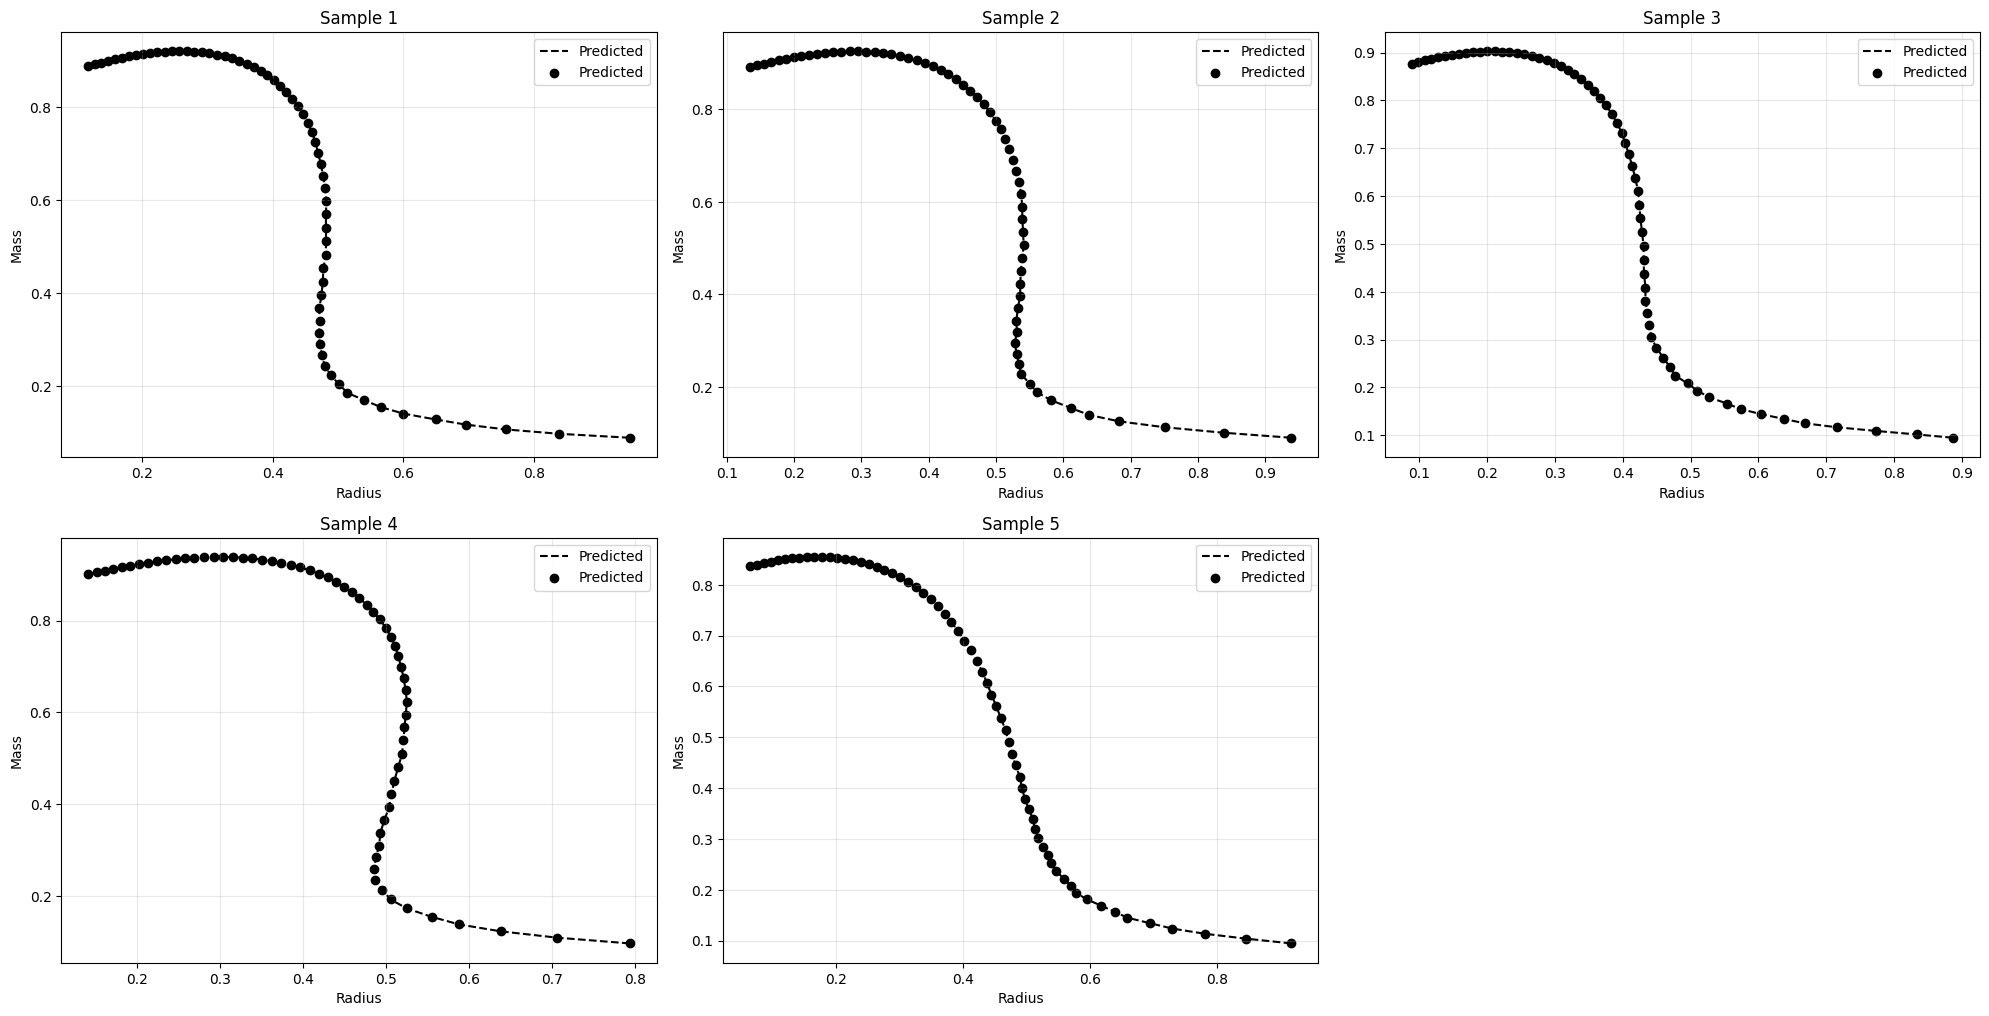

In [10]:
Y_scaled = np.load("data/Y_scaled.npy")

mass_pred_unscaled = Y_scaled[:, :, 0] 
radius_pred_unscaled = Y_scaled[:, :, 1] 

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for sample_idx in range(5):
    ax = axes[sample_idx]

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='black', label='Predicted')
    ax.scatter(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx], color='black', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(5, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Results

In [14]:
np.load("data/X_test.npy").shape

(1000, 64, 2)

In [11]:
metrics, preds = evaluate_model(model, np.load("data/X_test.npy"), np.load("data/y_test.npy"))
metrics

# calculate the error on Mass and the radius separately

{'MSE': 0.00042399170342832804,
 'R2': 0.9937882423400879,
 'MSE_Mass': 0.0005620581796392798,
 'R2_Mass': 0.9931406378746033,
 'MSE_Radius': 0.00028592513990588486,
 'R2_Radius': 0.9893576502799988}

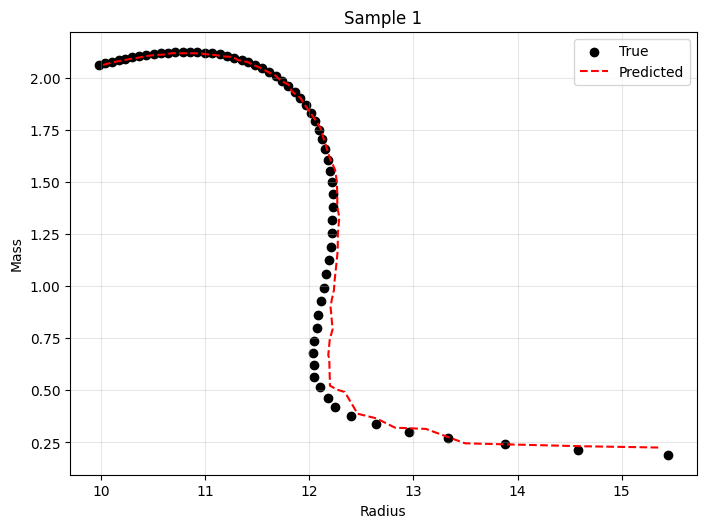

In [12]:
M_MAX = np.load("scalers/M_MAX.npy")
R_MAX = 16.0
R_MIN = np.load("scalers/R_MIN.npy")

y_test = np.load("data/y_test.npy")
mass_pred_unscaled = preds[:, :, 0] * M_MAX
radius_pred_unscaled = preds[:, :, 1] * (R_MAX - R_MIN) + R_MIN
# Inverse-transform true values
mass_true_unscaled = y_test[:, :, 0] * M_MAX
radius_true_unscaled = y_test[:, :, 1] * (R_MAX - R_MIN) + R_MIN

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()
sample_idx = 0
ax = axes[sample_idx]

# True M-R relation (black)
ax.scatter(radius_true_unscaled[sample_idx], mass_true_unscaled[sample_idx],
            color='black', label='True')

# Predicted M-R relation (red dashed line)
ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
        "--", color='red', label='Predicted')

ax.set_title(f'Sample {sample_idx + 1}')
ax.set_xlabel('Radius')
ax.set_ylabel('Mass')
ax.legend()
ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

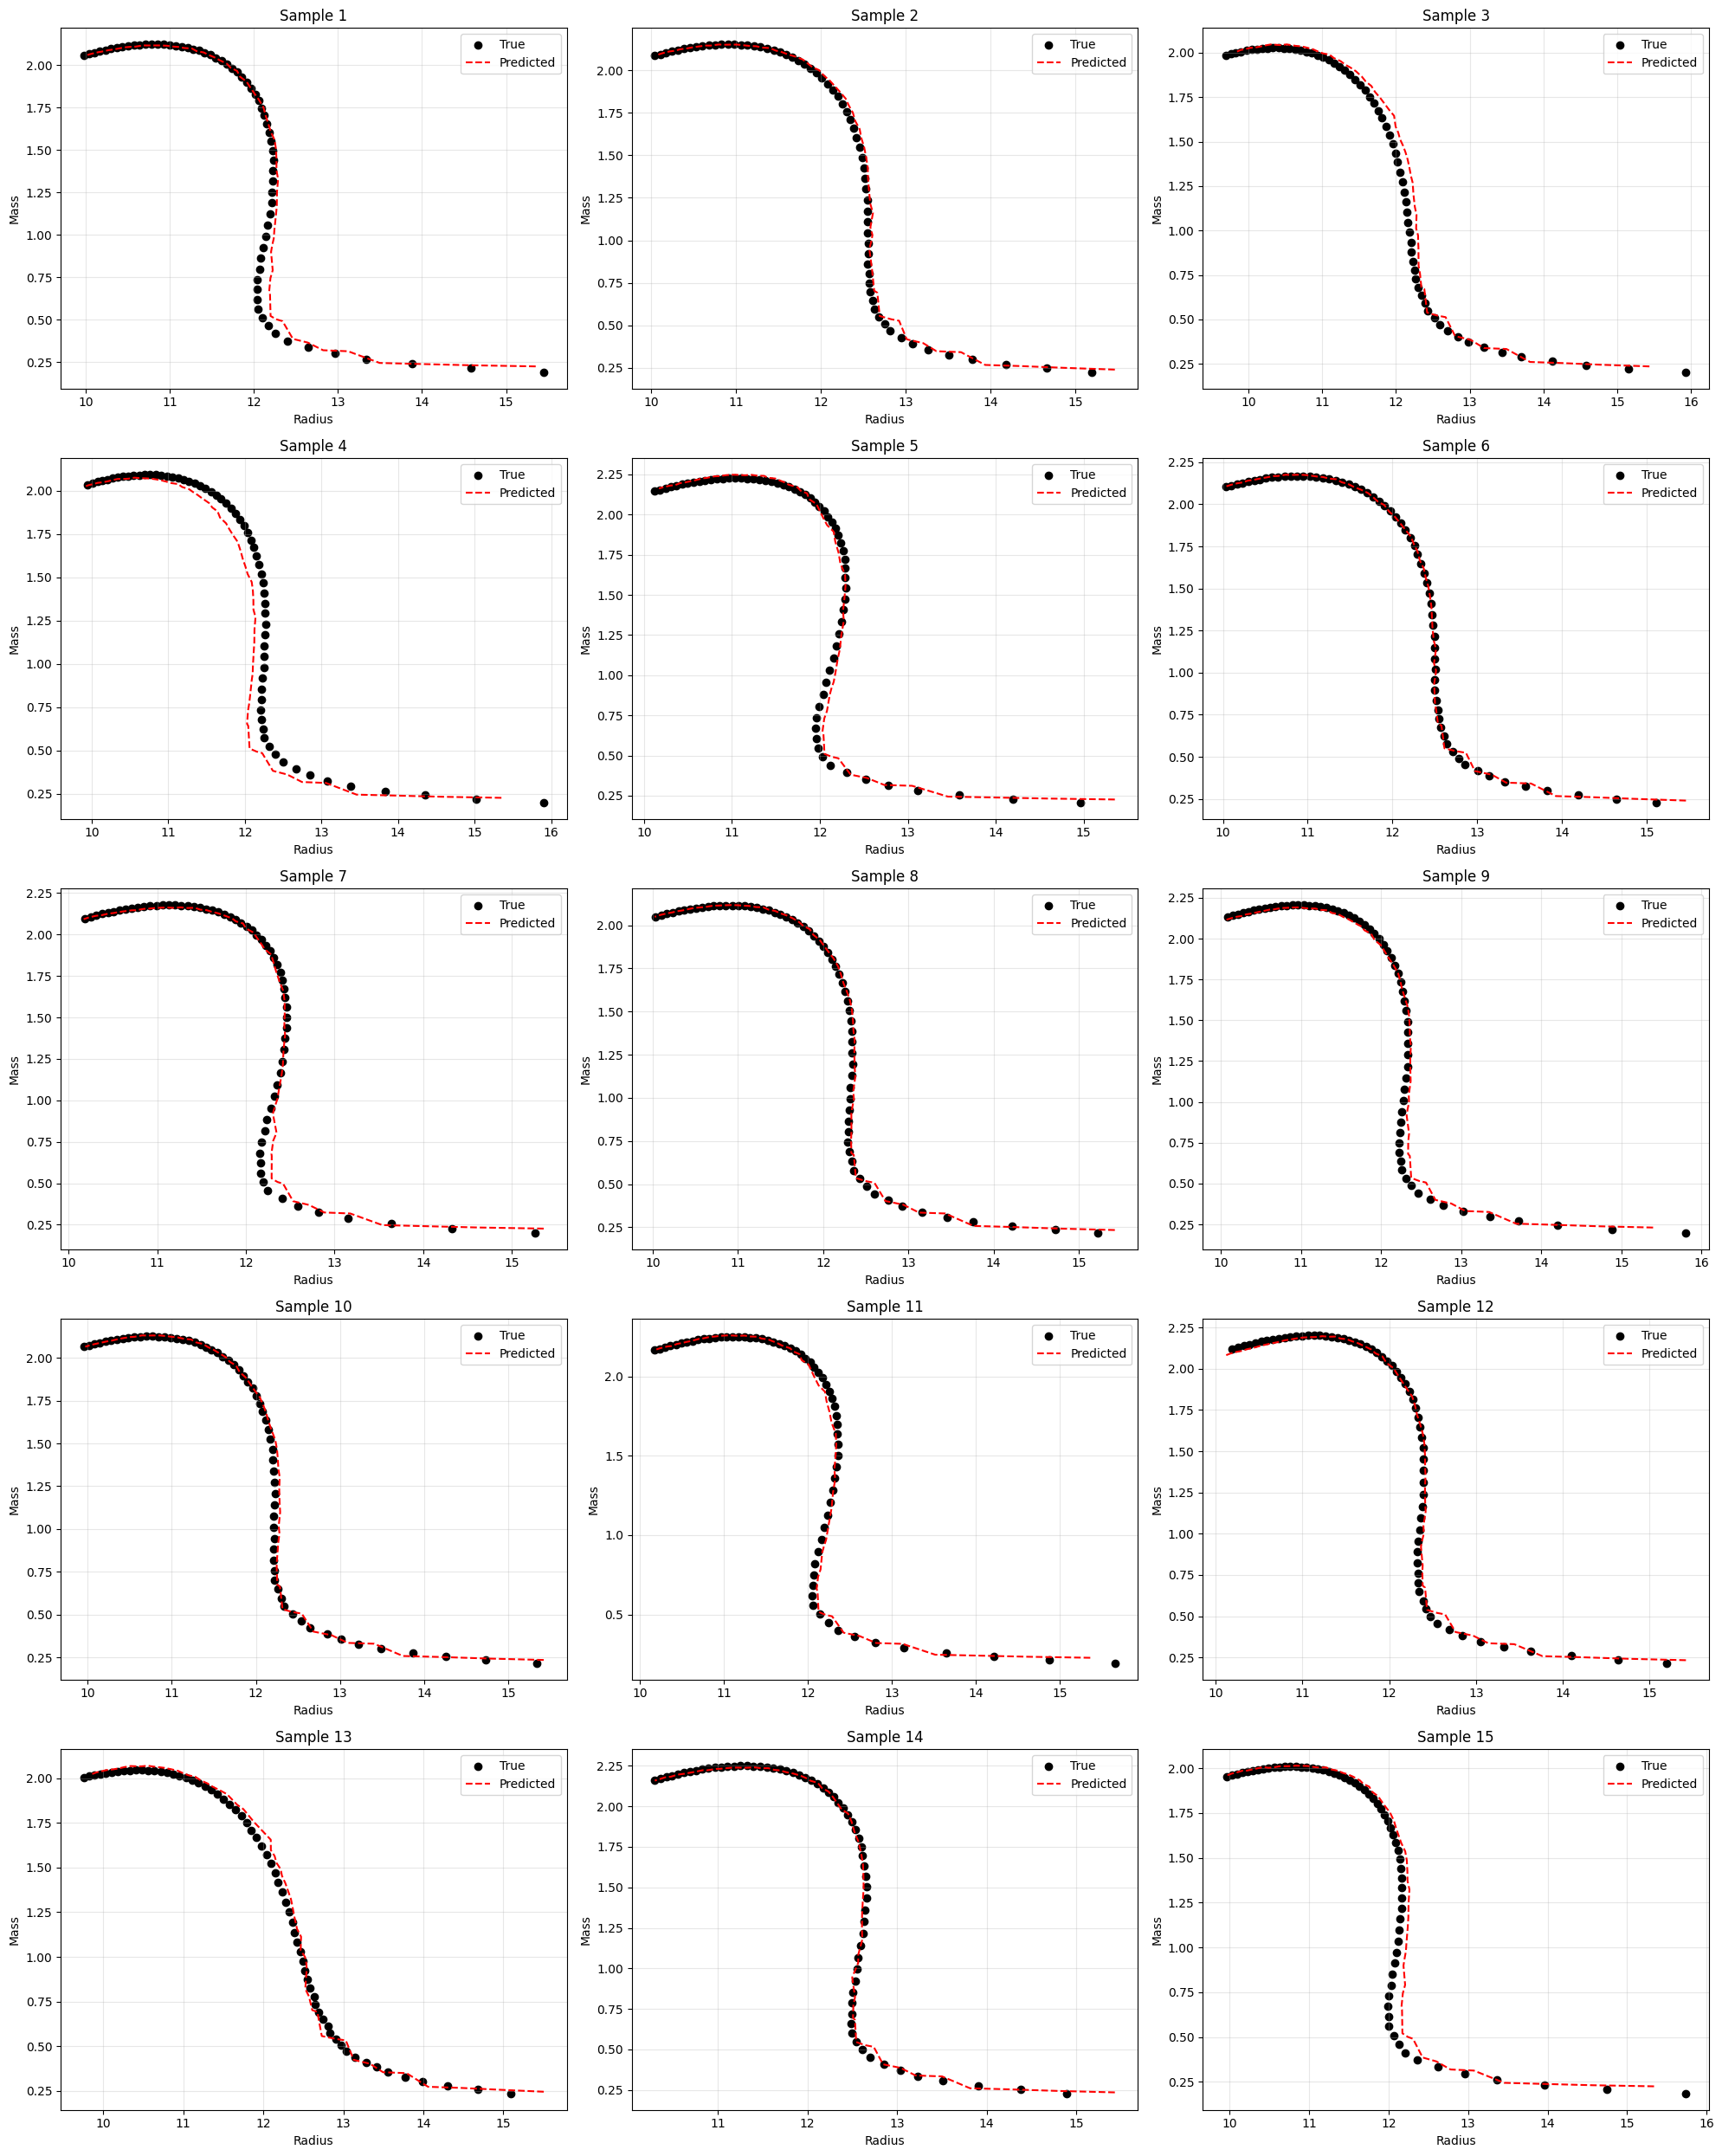

In [13]:

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()
for i in range(15):
    sample_idx = i
    ax = axes[sample_idx]

    # True M-R relation (black)
    ax.scatter(radius_true_unscaled[sample_idx], mass_true_unscaled[sample_idx],
                color='black', label='True')

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='red', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

plt.show()